# BBC News Classification

## Packages

In [1]:
# utilities
from typing import Tuple
import itertools
import pickle
import os
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter(action='ignore', category=FutureWarning)

# general purpose
import numpy as np
import pandas as pd 

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# text processing
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder

# model training and evaluating
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

# modeling algorithms
from sklearn.decomposition import NMF
from sklearn.ensemble import RandomForestClassifier

## Data

In [2]:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [3]:
train = pd.read_csv('data/bbc-news-data/BBC News Train.csv')
submission_test = pd.read_csv('data/bbc-news-data/BBC News Test.csv')
sample_solution = pd.read_csv('data/bbc-news-data/BBC News Sample Solution.csv')

# train = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Train.csv')
# submission_test = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Test.csv')
# sample_solution = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv')

## Exploratory data analysis 

First look at the structure of the datasets. 

In [4]:
print(f'Whole train dataset shape: {train.shape}')
print('Train dataset preview')
print(train.head())

Whole train dataset shape: (1490, 3)
Train dataset preview
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business


In [5]:
print('Preview of the test dataset for which we need to submit results')
print(submission_test.head())

Preview of the test dataset for which we need to submit results
   ArticleId                                               Text
0       1018  qpr keeper day heads for preston queens park r...
1       1319  software watching while you work software that...
2       1138  d arcy injury adds to ireland woe gordon d arc...
3        459  india s reliance family feud heats up the ongo...
4       1020  boro suffer morrison injury blow middlesbrough...


The train and submission datasets have the same structure except for the target. 

Now we look at the content of the news articles.

In [6]:
print(train['Text'].iloc[0])

worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebbe

How many words are in each news piece?

Distribution of text length in whole training dataset
count    1490.000000
mean      385.012752
std       210.898616
min        90.000000
25%       253.000000
50%       337.000000
75%       468.750000
max      3345.000000
Name: Text, dtype: float64


[Text(0.5, 1.0, 'Distribution of Text Length in Whole Training Dataset')]

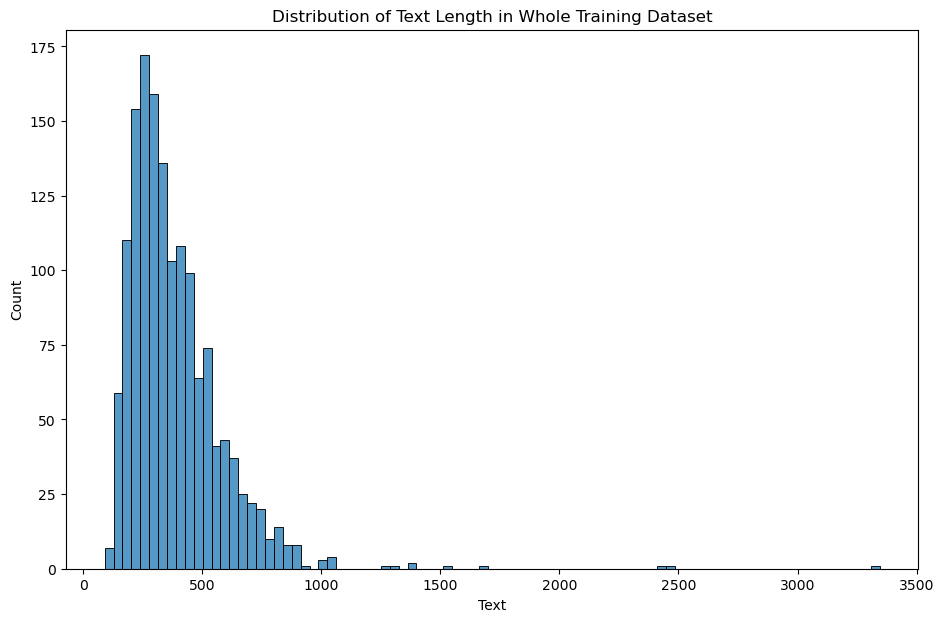

In [7]:
text_len = train['Text'].apply(lambda x: len(x.split()))
print('Distribution of text length in whole training dataset')
print(text_len.describe())
plt.figure(figsize=(11,7))
sns.histplot(data=text_len).set(title='Distribution of Text Length in Whole Training Dataset')

Now look at the target. 

Counts of news articles in each topic in whole training dataset
Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64


[Text(0.5, 1.0, 'Counts of News Articles in Each Topic in Whole Training Dataset')]

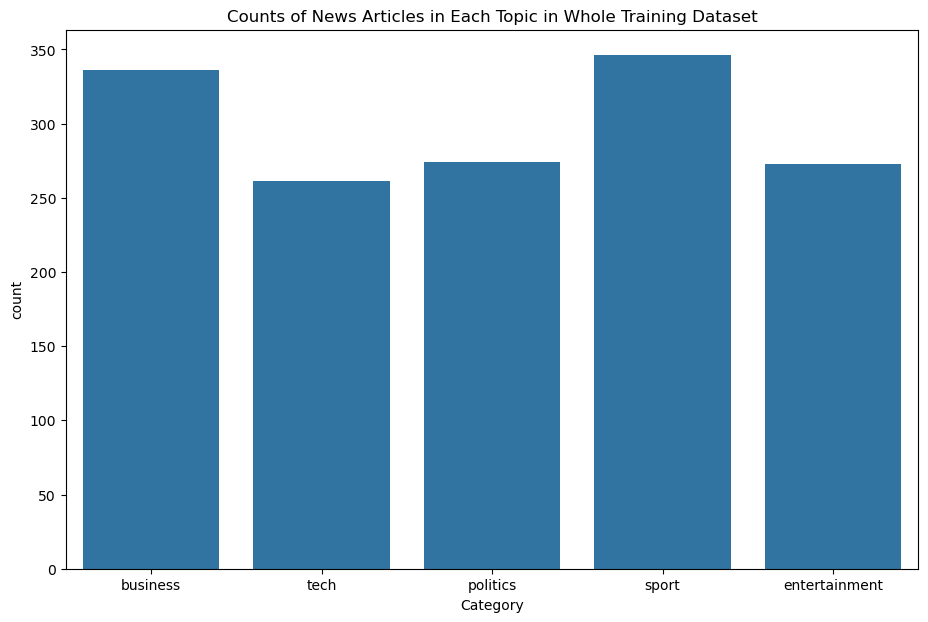

In [8]:
num_topics = train['Category'].nunique()
print('Counts of news articles in each topic in whole training dataset')
print(train['Category'].value_counts())
plt.figure(figsize=(11,7))
sns.countplot(train, x="Category").set(title='Counts of News Articles in Each Topic in Whole Training Dataset')

The topics seem to have a rather balanced distribution. 

### Analysis plan

We will first clean up the text data. As we observe from the example, it appears the text data has already gone through some processing. However we feel more cleaning is needed. There are special characters, some punctuations, and very common words such as "the" (known as stop words in natural language processing). Also in many places there is more than one space between words. All of these will be removed. 

The next step is tokenize and vectorize the words - just like in many natural language processing tasks. Many methods exist to vectorize tokens. However, for learning purpose, I would like to utilize the Non-Negative Matrix Factorization (NMF) method implemented in scikit-learn to fit the recommendation model. This limits our choices of vectorization methods, as NMF requires the token vectors to have only non-negative values. The TF-IDF (term frequency-inverse document frequency) vectorization algorithm guarantees that the embeddings it creates are always non-negative. Later in the "Word embedding matrices" section we include a brief description of TF-IDF. 

Certain routine preparations are needed before modeling, such as splitting the dataset into train and test datasets, transforming the target label into some form of numeric data (label encoding). 

When we complete these routine tasks, we will be ready to build a model. The first model we will build is the NMF model. We will use the default values for solving the matrix factorization. We do need to specify the number of "latent factors" to be the number of topics - this will give us a matrix whose shape is (number of news articles) x (number of topics). 

After training the model, we will use the model to generate predictions, and then compare the predictions to the true targets to evaluate the predictive accuracy of the model. Most of these steps are rather routine: calculating accuracy score, inspecting the confusion matrix, deciding whether the model demonstrates overfitting or underfitting by comparing the train and test performances, etc. What is special to this project is on generating predictions. NMF is not a supervised learning algorithm, and therefore the target it generates will not necessarily match the encoding of the true targets. We need another step to find the best matching label ordering based on the accuracy. After mapping the groups NMF generates to the groups of the target, we continue to transform the predictions to the topics using the trained label encoder. At this stage, each news article is predicted to be in a category that is "business" etc. rather than a number. 

We then proceed to improve the model. Both the NMF model and the TF-IDF vectorizer have hyperparameters that we can potentially tune. We will apply cross-validation and use grid search for this task. 

Model improvement does not stop at finding the optimal hyperparameters for the algorithms we initially pick - we can try out other algorithms. Here we continue to attempt to improve the model using a different word vectorization method - count vectorizer. 

The next step in the assignment is to compare matrix factorization to a supervised learning algorithm. We will build a random forest classification model and evaluate its performance.

The final step is to generate a submission file. The Kaggle challenge provides a sample submission file. All we need to do here is to output the predicted topics of the test data and organize the predictions into the same structure as the sample file. 

## Model training preparation

### Train and test datasets

In [9]:
train = train.set_index('ArticleId')

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(train['Text'], train['Category'], \
                                                                        test_size=0.2, random_state=0)

The text target is transformed to numeric values. 

In [10]:
label_encoder = LabelEncoder()

y_train = pd.DataFrame({'ArticleId': X_train_orig.index, \
                        'Category': label_encoder.fit_transform(y_train_orig)}).set_index('ArticleId')['Category']

y_test = pd.DataFrame({'ArticleId': X_test_orig.index, \
                        'Category': label_encoder.transform(y_test_orig)}).set_index('ArticleId')['Category']

### Text processing

The next four helper functions perform the text data cleaning described in the first paragraph of the analysis plan. 

In [11]:
def remove_punctuation(text):
    """remove all punctuation
    """
    return re.sub(r'[^\w\s]+', '', text)

In [12]:
def remove_number(text):
    """remove numbers
    """
    return re.sub(r'\d+', '', text)

In [13]:
nltk.download('stopwords', download_dir='nltk_downloads')
nltk.data.path.append('nltk_downloads')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to nltk_downloads...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
def remove_stopword(text):
    """remove stopwords
    """
    stop_words = stopwords.words('english')
    return ' '.join([word for word in text.split() if word not in (stop_words)])

In [15]:
def remove_extra_space(text):
    """when there are multiple spaces, consolidate them and leave only one whitespace. 
    """
    return re.sub(' +', ' ', text)

In [16]:
X_train_text_cleaned = X_train_orig.apply(remove_punctuation).apply(remove_number)\
    .apply(remove_stopword).apply(remove_extra_space)
X_test_text_cleaned = X_test_orig.apply(remove_punctuation).apply(remove_number)\
    .apply(remove_stopword).apply(remove_extra_space)

Perform similar EDA steps as in the earlier section, to show the effect of the cleaning. 

Distribution of text length in user-defined train dataset, after cleaning
count    1192.000000
mean      212.473993
std       114.113938
min        47.000000
25%       139.000000
50%       187.500000
75%       260.000000
max      1635.000000
Name: Text, dtype: float64


[Text(0.5, 1.0, 'Distribution of Text Length in User-Defined Training Dataset, After Cleaning')]

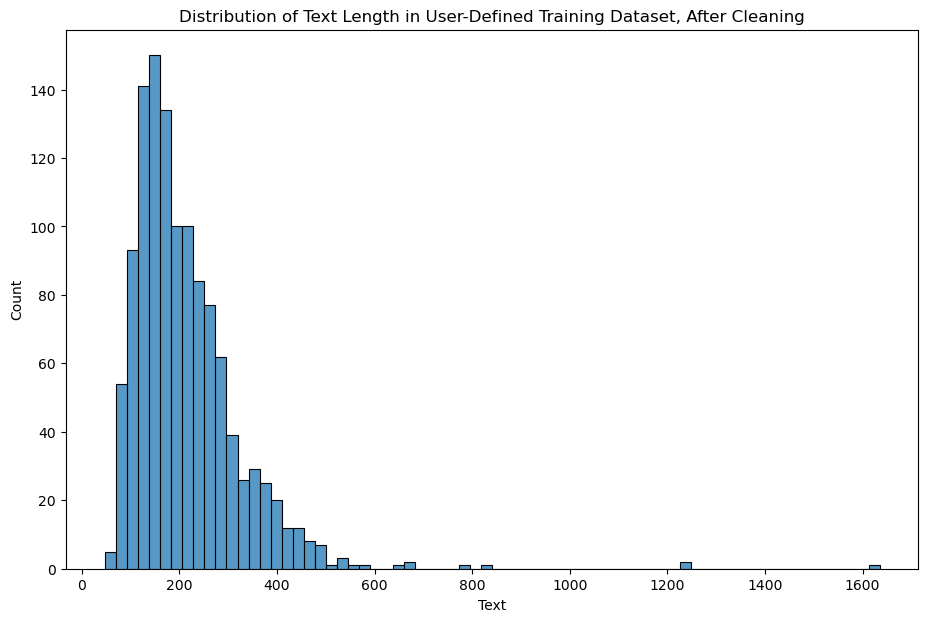

In [17]:
cleaned_text_len = X_train_text_cleaned.apply(lambda x: len(x.split()))
print('Distribution of text length in user-defined train dataset, after cleaning')
print(cleaned_text_len.describe())
plt.figure(figsize=(11,7))
sns.histplot(data=cleaned_text_len)\
    .set(title='Distribution of Text Length in User-Defined Training Dataset, After Cleaning')

Comparing the summary statistics to those of the raw text data, we can see that we have removed about half of the words. The shape of the distribution remains similar to that before the cleaning.

### Word embedding matrices

As noted in the analysis plan, we choose TF-IDF vectorizer because it returns non-negative word embeddings. 

This vectorization algorithm is built upon two scores: Term Frequency (TF), and Inverse Document Frequency (IDF).

TF measures how often a word appears in a document. It is calculated as the ratio of the number of times a term appears in a document to the total number of terms in that document. IDF measures the rarity of a term across the entire collection of documents (known as corpus in natural language processing). It is calculated as the logarithm of the ratio of the total number of documents in the corpus to the number of documents containing the term of interest, with the result being inverted. Then the TF-IDF score for a term in a document is obtained by multiplying its TF and IDF scores. This process is repeated for each term in each document, resulting in a vector representation where each dimension corresponds to a unique term and the value of each dimension is its TF-IDF score.

The point of TF is to give higher weights to terms that appear more frequently in a document, assuming that they are more important in representing the content of that specific document. The idea behind IDF is to give higher weights to terms that are rare across the entire corpus, assuming that they are more discriminative.

The code to convert the text data into embedding matrices is wrapped into the `train_nmf_model` and later the `train_rf_model` functions for the sake of reusing code. 

### Label permutation

Here we find the best label match based on the accuracy, as discussed in the analysis plan. 

In [18]:
def label_permute_compare(y_true, y_pred, n):

    best_permutation = None
    best_accuracy = 0.0
    best_predicted_labels = None

    unique_labels_true = sorted(set(y_true))

    unique_labels_predicted = sorted(set(y_pred))

    assert len(unique_labels_true) == n, \
        "the number of labels in actual data does not agree with what's specified in the parameter n"

    assert len(unique_labels_predicted) == n, \
        "the number of labels in predicted data does not agree with what's specified in the parameter n"

    # generate all possible permutations of the predicted labels
    predicted_permutations = itertools.permutations(unique_labels_predicted)
    
    all_mappings = []

    for each_permutation in predicted_permutations:
        # each mapping dictionary follows this format: {NMF-predicted label: label-encoded true label}
        mapping = {key: value for key, value in zip(each_permutation, unique_labels_true)}
        all_mappings.append(mapping)

    for each_mapping in all_mappings:
        # apply the mapping to the predicted labels
        # result is a numpy array, each element is a label-encoded predicted topic
        mapped_predicted_labels = np.vectorize(each_mapping.get)(y_pred)
        accuracy = accuracy_score(y_true, mapped_predicted_labels)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_mapping = each_mapping

    best_predicted_labels = np.vectorize(best_mapping.get)(y_pred)
    
    return best_mapping, best_accuracy, best_predicted_labels

### Model performance

We use accuracy to measure predictive performance. To show more details, we use confusion matrix to examine our performance within each category of the target.

In [19]:
def show_performance(encoded_train_target_pred, encoded_test_target_pred, target_encoder, \
                     encoded_train_target_true, encoded_test_target_true, model_type, show_result_plot=False):
    """
    encoded_train_target_pred: Predictions made by the algorithm, in train dataset. These values are label-encoded. 
        If the algorithm is NMF, these values are already matched via permutation.
    encoded_test_target_pred: Similar to encoded_train_target_pred, but predictions in test dataset. 
    target_encoder: The label encoder that transforms the target topic.
    encoded_train_target_true: True target of the train dataset, label-encoded.
    encoded_test_target_true: Similar to encoded_train_target_true, but of test dataset. 
    model_type: Name of the algorithm for display. 
    show_result_plot: Whether to show the results when this function executes. Often we want to look at the results,
        but one use case is to run this function a few times and put the accuracy scores into a table. 
    """
    
    y_train_pred_formatted = target_encoder.inverse_transform(encoded_train_target_pred)
    y_test_pred_formatted = target_encoder.inverse_transform(encoded_test_target_pred)
    
    y_train_orig = target_encoder.inverse_transform(encoded_train_target_true)
    y_test_orig = target_encoder.inverse_transform(encoded_test_target_true)
    
    train_acc = accuracy_score(y_train_orig, y_train_pred_formatted)
    test_acc = accuracy_score(y_test_orig, y_test_pred_formatted)
    
    if show_result_plot == True:
        print(f'{model_type}, train accuracy: {train_acc:.4f}')
        print(f'{model_type}, test accuracy: {test_acc:.4f}')

        disp = ConfusionMatrixDisplay.from_predictions(y_train_orig, y_train_pred_formatted, \
                                                       xticks_rotation='vertical')
        disp.ax_.set_title(f"{model_type}, in train data")
        plt.show()

        disp = ConfusionMatrixDisplay.from_predictions(y_test_orig, y_test_pred_formatted, \
                                                       xticks_rotation='vertical')
        disp.ax_.set_title(f"{model_type}, in test data")
        plt.show()

    return train_acc, test_acc

## Model training: NMF

We put a few steps into one function as we will repeat these steps a few times. Specifcally, the function below
* converts the text data into word embedding matrices
* defines the NMF model
* generates the predictions
* executes the label permutation function to find the mapping between the topics and the groups the NMF model finds
* for the model predictions, transforms numeric label targets back to the original topics
* shows and eventually returns the train and test accuracy scores
* shows the train and test confusion matrices
* persists the necessary artifacts: trained vectorizer, trained model, the mapping between NMF groups and the labels

In [20]:
def train_nmf_model(word_vectorizer_definition, nmf_model_definition, \
                    train_text, test_text, \
                    train_target, test_target, \
                    show_result_plot=False, save_model=False) -> Tuple[float, float]:
    
    X_train = word_vectorizer_definition.fit_transform(train_text)
    X_test = word_vectorizer_definition.transform(test_text)
    
    nmf_model_definition.fit(X_train)
    
    train_pred_representation = nmf_model_definition.transform(X_train)
    test_pred_representation = nmf_model_definition.transform(X_test)

    y_train_pred = train_pred_representation.argmax(axis=1)
    y_test_pred = test_pred_representation.argmax(axis=1)
    
    best_mapping, best_train_accuracy, _ = label_permute_compare(y_true=train_target, \
                                                                 y_pred=y_train_pred, \
                                                                 n=num_topics)
    if save_model == True:
        with open('models/vectorizer.pkl', 'wb') as f:
            pickle.dump(word_vectorizer_definition, f)
        with open('models/nmf_model.pkl', 'wb') as f:
            pickle.dump(nmf_model_definition, f)
        with open('models/nmf_model_mapping.pkl', 'wb') as f:
            pickle.dump(best_mapping, f)

#     if save_model == True:
#         with open('/kaggle/working/vectorizer.pkl', 'wb') as f:
#             pickle.dump(word_vectorizer_definition, f)
#         with open('/kaggle/working/nmf_model.pkl', 'wb') as f:
#             pickle.dump(nmf_model_definition, f)
#         with open('/kaggle/working/nmf_model_mapping.pkl', 'wb') as f:
#             pickle.dump(best_mapping, f)
    
    y_train_pred_matched = np.vectorize(best_mapping.get)(y_train_pred)
    y_test_pred_matched = np.vectorize(best_mapping.get)(y_test_pred)

    train_acc, test_acc = show_performance(y_train_pred_matched, y_test_pred_matched, label_encoder, \
                                           train_target, test_target, 'NMF model', show_result_plot)
    
    return train_acc, test_acc

NMF model, train accuracy: 0.9211
NMF model, test accuracy: 0.9060


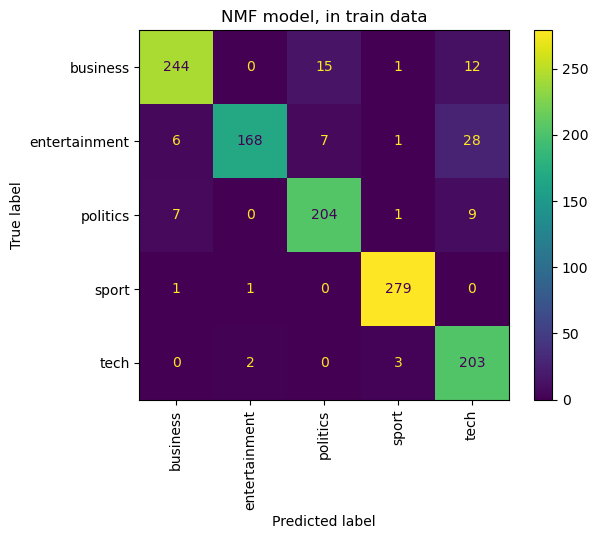

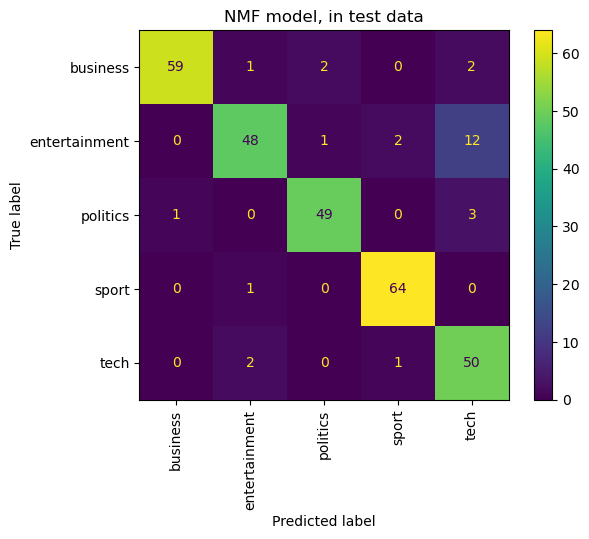

In [21]:
nmf_model_initial = NMF(n_components=num_topics, random_state=0)
nmf_train_acc, nmf_test_acc = train_nmf_model(word_vectorizer_definition=TfidfVectorizer(), \
                                              nmf_model_definition=nmf_model_initial, \
                                              train_text=X_train_text_cleaned, \
                                              test_text=X_test_text_cleaned, \
                                              train_target=y_train, \
                                              test_target=y_test, \
                                              show_result_plot=True, \
                                              save_model=False)

### Hyperparameter tuning

Earlier in the analysis plan we mentioned that both the TF-IDF vectorizer and the NMF model have hyperparameters, which we can tune to potentially improve the model performance. Here we choose to tune the `ngram_range`, `max_df`, and `min_df` of TF-IDF vectorizer and `alpha_W` and `alpha_H` for the NMF model. 

`max_df` and `min_df` give the thresholds about terms to ignore when building the vocabulary. `ngram_range` decides whether we use unigrams or bigrams to extract terms. `alpha_W` controls the regularization terms of W; similarly, `alpha_H` controls the regularization terms of H.

In [ ]:
simplefilter("ignore", category=ConvergenceWarning)

def custom_scoring(estimator, X, y_true):
    y_pred_representation = estimator.transform(X)
    y_pred = y_pred_representation.argmax(axis=1)
    _, _, y_mapped = label_permute_compare(y_true, y_pred, num_topics)
    return accuracy_score(y_true, y_mapped)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nmf', NMF(n_components=num_topics, random_state=0))
])

param_grid = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__min_df': [1, 2, 5],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'nmf__alpha_W': [0, 0.00001, 0.00005],
    'nmf__alpha_H': [0, 0.00001, 0.00005],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=custom_scoring)

grid_search.fit(X_train_text_cleaned, y_train)

In [ ]:
# Print the best hyperparameters and corresponding accuracy
print(f"Best hyperparameters from cross-validation: {grid_search.best_params_}")
print(f"Best accuracy from cross-validation: {grid_search.best_score_:.4f}")

The best alpha H and alpha W are their default values, 0. But cross-validation manages to find optimal values for the TF-IDF vectorizer. 

In [ ]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['param_nmf__alpha_H', \
                                                    'param_nmf__alpha_W', \
                                                    'param_tfidf__max_df', \
                                                    'param_tfidf__min_df', \
                                                    'param_tfidf__ngram_range', \
                                                    'mean_test_score', \
                                                    'std_test_score', \
                                                    'rank_test_score']]
print('Number of hyperparameter combinations tested:', len(cv_results))

Here we summarize the different hyperparameter combinations and their corresponding results. However, we have tested 162 combinations - too many to show in this notebook. The summary table below gives the hyperparameters that yield the top 10 performance. 

In [ ]:
print(cv_results.sort_values(by=['rank_test_score']).head(n=10))

### Model improvement

#### Improved TF-IDF vectorization

Now we use the best hyperparameters found in the previous step to re-train the model. 

In [ ]:
tfidf_vectorizer_tuned = TfidfVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))

nmf_model_tuned = NMF(n_components=num_topics, alpha_H=0, alpha_W=0, random_state=0)

nmf_tuned_train_acc, nmf_tuned_test_acc = train_nmf_model(word_vectorizer_definition=tfidf_vectorizer_tuned, \
                                                          nmf_model_definition=nmf_model_tuned, \
                                                          train_text=X_train_text_cleaned, \
                                                          test_text=X_test_text_cleaned, \
                                                          train_target=y_train, \
                                                          test_target=y_test, \
                                                          show_result_plot=True, \
                                                          save_model=True)

The predictive performances are close between the training data and the test data, and they are both above 90%. This indicates that our model describes the data adequately and generates to new data well. 

#### Other attempt: a different feature extraction method

Many approaches exist to improve models. We have tried hyperparameter tuning. Will a different way to vectorize the words improve the model?

Here we try the count vectorizer. This vectorizer also only yields non-negative values.

In [ ]:
count_vectorizer = CountVectorizer()

nmf_model_count_vec = NMF(n_components=num_topics, alpha_H=0, alpha_W=0, random_state=0)

nmf_count_train_acc, nmf_count_test_acc = train_nmf_model(word_vectorizer_definition=count_vectorizer, \
                                                          nmf_model_definition=nmf_model_count_vec, \
                                                          train_text=X_train_text_cleaned, \
                                                          test_text=X_test_text_cleaned, \
                                                          train_target=y_train, \
                                                          test_target=y_test, \
                                                          show_result_plot=True, \
                                                          save_model=False)

Count vectorizer does not improve the model. We will stick to TF-IDF vectorizer. 

## Model training: supervised learning algorithm

The next step is to compare NMF to a supervised learning modeling method. My go-to supervised learning algorithm is Random Forest. It usually yields a reasonable performance without a lot of tuning. 

### Random forest model

In [ ]:
def train_rf_model(word_vectorizer_definition, \
                    train_text, test_text, \
                    train_target, test_target, show_result_plot) -> Tuple[float, float]:
    
    X_train = word_vectorizer_definition.fit_transform(train_text)
    X_test = word_vectorizer_definition.transform(test_text)
    
    rf_classifier = RandomForestClassifier(n_estimators=128, random_state=0)
    rf_classifier.fit(X_train, train_target)

    train_predictions = rf_classifier.predict(X_train)
    
    test_predictions = rf_classifier.predict(X_test)
    
    train_acc, test_acc = show_performance(train_predictions, test_predictions, label_encoder, \
                                           train_target, test_target, 'Random Forest model', show_result_plot)
    
    return train_acc, test_acc

In [ ]:
rf_train_acc, rf_test_acc = train_rf_model(word_vectorizer_definition=tfidf_vectorizer_tuned, \
                                              train_text=X_train_text_cleaned, test_text=X_test_text_cleaned, \
                                              train_target=y_train, test_target=y_test, show_result_plot=True)    

So far, Random Forest outperforms NMF in both train and test performance. 

## Discussion

The random forest model outperforms the NMF model on 100% of train dataset we created. How would the results change with different sizies of train data? In other words, which algorithm is more data-efficient? Now we compare the performances of these two algorithms by training them on 10%, 20%, and 50% of our train dataset.

### Data efficiency

In [ ]:
columns = ['train_sample_ratio', 'nmf_train_accuracy', 'nmf_test_accuracy', \
           'rf_train_accuracy', 'rf_test_accuracy']

data_efficiency = pd.DataFrame(columns=columns)

del columns

sample_data_ratio_range = (0.1, 0.2, 0.5)

for train_data_ratio in sample_data_ratio_range:

    # Specify the number of rows to sample
    num_rows_to_sample = int(np.floor(X_train_text_cleaned.shape[0] * train_data_ratio))

    sampled_X_train_text_cleaned = X_train_text_cleaned.sample(n=num_rows_to_sample, replace=False)

    sampled_indices = sampled_X_train_text_cleaned.index

    sampled_y_train = y_train[sampled_indices].copy()

#     tfidf_vectorizer_tuned = TfidfVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2))
    nmf_model_small = NMF(n_components=num_topics, alpha_H=0, alpha_W=0, random_state=0)

    nmf_train_acc, nmf_test_acc = train_nmf_model(word_vectorizer_definition=tfidf_vectorizer_tuned, \
                                                          nmf_model_definition=nmf_model_small, \
                                                          train_text=sampled_X_train_text_cleaned, \
                                                          test_text=X_test_text_cleaned, \
                                                          train_target=sampled_y_train, \
                                                          test_target=y_test, \
                                                          show_result_plot=False, \
                                                          save_model=False)      

    rf_train_acc, rf_test_acc = train_rf_model(word_vectorizer_definition=tfidf_vectorizer_tuned, \
                                                  train_text=sampled_X_train_text_cleaned, \
                                                  test_text=X_test_text_cleaned, \
                                                  train_target=sampled_y_train, test_target=y_test, \
                                                  show_result_plot=False)    

    new_row = pd.DataFrame({'train_sample_ratio': [train_data_ratio],
               'nmf_train_accuracy': [nmf_train_acc],
               'nmf_test_accuracy': [nmf_test_acc],
               'rf_train_accuracy': [rf_train_acc], 
               'rf_test_accuracy': [rf_test_acc],
              })

    data_efficiency = pd.concat([data_efficiency, new_row], ignore_index=True)

In [ ]:
print(data_efficiency)

Random Forest requires a smaller amount of data to achieve similar results compared to NMF. Neither algorithms demonstrates overfitting. 

## Submission file

In [ ]:
print(sample_solution.head())

In [ ]:
submission = submission_test.set_index('ArticleId')

with open('models/vectorizer.pkl', 'rb') as f:
    word_vectorizer_saved = pickle.load(f)
            
with open('models/nmf_model.pkl' , 'rb') as f:
    nmf_model_saved = pickle.load(f)
    
with open('models/nmf_model_mapping.pkl' , 'rb') as f:
    best_mapping_saved = pickle.load(f)
    
# with open('/kaggle/working/vectorizer.pkl', 'rb') as f:
#     word_vectorizer_saved = pickle.load(f)
            
# with open('/kaggle/working/nmf_model.pkl' , 'rb') as f:
#     nmf_model_saved = pickle.load(f)
    
# with open('/kaggle/working/nmf_model_mapping.pkl' , 'rb') as f:
#     best_mapping_saved = pickle.load(f)    

submission_test_cleaned = word_vectorizer_saved.transform(submission['Text'].apply(remove_punctuation)\
                                                         .apply(remove_number).apply(remove_stopword)\
                                                         .apply(remove_extra_space))

submission_pred_representation = nmf_model_saved.transform(submission_test_cleaned)
submission_pred = submission_pred_representation.argmax(axis=1)
submission_pred_formatted = label_encoder.inverse_transform(np.vectorize(best_mapping_saved.get)(submission_pred))

submission['Category'] = submission_pred_formatted

submission = submission.drop(columns=['Text']).reset_index()

submission.to_csv('submission/submission.csv', index=False)
# submission.to_csv('/kaggle/working/submission.csv', index=False)

## Reference

1. Jason Brownlee (August 7, 2019). What Are Word Embeddings for Text? https://machinelearningmastery.com/what-are-word-embeddings

2. tf-idf. Wikipedia. https://en.wikipedia.org/wiki/Tf%E2%80%93idf